### Libraries

In [2]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import delta_manager.camera as Camera
from delta_manager.delta_manager import DeltaManager

In [3]:
import os
import glob
import itertools
from matplotlib.patches import Polygon

from ultralytics import YOLO

In [4]:
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (0, 0, 255)
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (0, 255, 255)
PINK = (255, 0, 255)
GRAY = (50, 50, 50)
ORANGE = (0, 128, 255)

THRESHOLD_FILE = './delta_manager/parameters/Thresholds.npy'
GRIPPER_SIZE = (2, 2)

### Functions

In [5]:
def find_key(dictionary, val):
    return list(dictionary.keys())[list(dictionary.values()).index(val)]

def plot_image(image, convert_to_rgb=True, sub=False, ax=None):
	img = image.copy()
	if convert_to_rgb:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

	if sub:
		return img

	if ax:
		ax.axis('off')
		ax.imshow(img)
	else:
		plt.axis('off')
		plt.imshow(img)
		plt.show()
	return

def draw_grid_lines(image, side_stude_ratio, color, line_size=1, ax=None):
    x, y = image.shape[0], image.shape[1]
    grid = image.copy()

    # Make the image more transparent
    grid = cv2.addWeighted(grid, 0.6, np.zeros(grid.shape, grid.dtype), 0, 0)
    
    for i in range(0, x, int(1/side_stude_ratio)):
        cv2.line(grid, (0, i), (y, i), color, line_size)
    for i in range(0, y, int(1/side_stude_ratio)):
        cv2.line(grid, (i, 0), (i, x), color, line_size)

    plot_image(grid, ax=ax)

def cut_to_mask(image, mask):
    x, y, w, h = cv2.boundingRect(mask)
    return image[y:y+h, x:x+w].copy()


In [6]:
def make_chessboard(image, height, width, square_size=1):
    # Draw the squares
    for i in range(0, height, square_size*2):
        for j in range(0, width, square_size*2):
            image[i:i+square_size, j:j+square_size] = GRAY
            image[i+square_size:i+square_size*2, j+square_size:j+square_size*2] = GRAY

def create_brick_range(brick):
    col, row = brick['size']
    x, y = brick['coordinates']
    angel = np.deg2rad(brick['angel'])

    rotation_matrix = np.array([[np.cos(angel), np.sin(angel)], [-np.sin(angel), np.cos(angel)]])
    (delta_x, delta_y) = np.dot(rotation_matrix, np.array([col, row]))

    if delta_x > 0:
        from_x = x
        to_x = x + round(delta_x)
    elif delta_x < 0:
        from_x = x + round(delta_x) + 1
        to_x = x + 1
    
    if delta_y > 0:
        from_y = y
        to_y = y + round(delta_y)
    elif delta_y < 0:
        from_y = y + round(delta_y) + 1
        to_y = y + 1
    
    brick_range = {
        'x_range':(from_x, to_x),
        'y_range':(from_y, to_y)
    }
    return brick_range

def get_coords_from_range(brick_range):
    from_x, to_x = brick_range['x_range']
    from_y, to_y = brick_range['y_range']
    brick_coordinates = []
    for x in range(from_x, to_x):
        for y in range(from_y, to_y):
            brick_coordinates.append((x, y))
    return brick_coordinates

def draw_brick(image, brick_coordinates, color):
    for x,y in brick_coordinates:
        if color == 'Blue' or color == 'b':
            image[y, x] = BLUE
        elif color == 'Red' or color == 'r':
            image[y, x] = RED
        elif color == 'Yellow' or color == 'y':
            image[y, x] = YELLOW
        elif color == 'Pink':
            image[y, x] = PINK
        elif color == 'Green' or color == 'g':
            image[y, x] = GREEN
        elif color == 'Orange':
            image[y, x] = ORANGE
        else:
            print('Invalid color')
            image[y, x] = BLACK

def add_brick_to_table(table, brick_coordinates, brick_id):
    for x, y in brick_coordinates:
        table[y, x] = brick_id

def make_table(bricks, width, height):
    table = np.zeros((height, width), dtype=np.uint8)
    for brick in bricks:
        brick_range = create_brick_range(brick)
        brick_coordinates = get_coords_from_range(brick_range)
        add_brick_to_table(table, brick_coordinates, brick['id'])
    return table

def make_board(bricks, width, height, chess_like=False):
    board = np.zeros((height, width, 3), dtype=np.uint8)
    if chess_like:
        make_chessboard(board, height, width)
    for brick in bricks:
        brick_range = create_brick_range(brick)
        brick_coordinates = get_coords_from_range(brick_range)
        draw_brick(board, brick_coordinates, brick['color'])
    return board

def remove_brick_from_table(table, brick_coordinates):
    for x, y in brick_coordinates:
        table[y, x] = 0

def sort_bricks_by_score(bricks, table):
    bricks_with_score = []
    for brick in bricks:
        brick_range = create_brick_range(brick)
        brick_coordinates = get_coords_from_range(brick_range)
        score = score_brick_from_table(table, brick_range)
        bricks_with_score.append((brick, score))
    bricks_with_score.sort(key=lambda x: x[1], reverse=True)
    return [brick[0] for brick in bricks_with_score]
    
def score_brick_from_table(table, brick_range):
    score = 0
    grasp_points = find_grasp_areas(brick_range)
    for grasp_point in grasp_points:
        point_values = [table[point[1], point[0]] for point in grasp_point]
        if all(value == 0 for value in point_values):
            score += 1
    return score

def draw_grasp_areas(table, grasp_areas):
	if grasp_areas is None:
		return
	if len(np.shape(grasp_areas)) != 3: # single grasp area
		for point in grasp_areas:
			table[point[1], point[0]] = 2
	else:
		for i, grasp_area in enumerate(grasp_areas):
			for point in grasp_area:
				table[point[1], point[0]] = 2

def draw_grasp_on_board(board, grasp_mask):
    for point in grasp_mask:
        board[point[1], point[0]] = WHITE

def is_colided_point(table, point):
    return table[point[1], point[0]] != 0

def is_something_between_rows(table, col, from_x, to_x, from_y, to_y):
    if col < from_x or col >= to_x:
        for row in range(from_y, to_y):
            if is_colided_point(table, (col, row)):
                return True
    return False

def is_something_between_cols(table, row, from_x, to_x, from_y, to_y):
    if row < from_y or row >= to_y:
        for col in range(from_x, to_x):
            if is_colided_point(table, (col, row)):
                return True
    return False
    
def find_grasp_areas(table, brick_range):
    from_x, to_x = brick_range['x_range']
    from_y, to_y = brick_range['y_range']
    grasp_areas = []
    grasp_scores = []
    
    g_x, g_y = GRIPPER_SIZE
    for col in range(from_x-g_x+1, to_x):
        grasp_area = []
        collision_flag = False
        for i in range(g_x):
            if is_something_between_rows(table, col+i, from_x, to_x, from_y, to_y):
                collision_flag = True
                break

            for j in range(g_y):
                upper_point = (col+i, from_y-g_y+j)
                lower_point = (col+i, to_y+j)
                if is_colided_point(table, upper_point) or is_colided_point(table, lower_point):
                    collision_flag = True
                    break

                grasp_area.append(upper_point)
                grasp_area.append(lower_point)
            
            if collision_flag:
                break
        
        if collision_flag:
            continue

        if col < from_x:
            score = g_x - abs(from_x - col)
        elif col > to_x - g_x:
            score = abs(to_x - col)
        else:
            score = g_x
            
        grasp_scores.append(score)
        grasp_areas.append(grasp_area)
    
    for row in range(from_y-g_y+1, to_y):
        grasp_area = []
        collision_flag = False
        for j in range(g_y):
            if is_something_between_cols(table, row+j, from_x, to_x, from_y, to_y):
                collision_flag = True
                break

            for i in range(g_x):
                left_point = (from_x-g_x+i, row+j)
                right_point = (to_x+i, row+j)
                if is_colided_point(table, left_point) or is_colided_point(table, right_point):
                    collision_flag = True
                    break

                grasp_area.append(left_point)
                grasp_area.append(right_point)

            if collision_flag:
                break
        
        if collision_flag:
            continue

        if row < from_y:
            score = g_y - abs(from_y - row)
        elif row > to_y - g_y:
            score = abs(to_y - row)
        else:
            score = g_y
        
        grasp_scores.append(score)
        grasp_areas.append(grasp_area)
    
    # sort areas by score
    grasp_areas = [area for _, area in sorted(zip(grasp_scores, grasp_areas), reverse=True)]
    return grasp_areas

def find_valid_grasp_area(table, brick_range):
	grasp_areas = find_grasp_areas(table, brick_range)
	if grasp_areas:
		return grasp_areas[0]
	return None

def find_best_grasp_area(table, brick_range):
	grasp_areas = find_grasp_areas(table, brick_range)
	
	return None

def show_image(image, window_name, size=(500, 500)):
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.imshow(window_name, image)
    cv2.resizeWindow(window_name, size[0], size[1])


In [7]:
def nothing(value):
    pass

def LoadBlobThresholds():
    params_to_load = np.load(THRESHOLD_FILE)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.filterByCircularity = True

    params.minThreshold    = params_to_load[0]
    params.maxThreshold    = params_to_load[1]
    params.minArea         = params_to_load[2]
    params.minCircularity  = params_to_load[3]

    return params

def FindCircles(img, params=None):
    if params is None:
        params = LoadBlobThresholds()
    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    # Detect blobs
    keypoints = detector.detect(img)

    return keypoints

def FindContours(img, target, threshold_area=5):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    if target == 'blue' or target == 'b':
        # lower = np.array([89, 158, 147])
        # upper = np.array([116, 255, 255])
        lower = np.array([105, 83, 139])
        upper = np.array([124, 255, 255])
    elif target == 'red' or target == 'r':
        # lower = np.array([0, 108, 198])
        # upper = np.array([18, 255, 255])
        lower = np.array([130, 75, 75])
        upper = np.array([180, 255, 255])
    elif target == 'green' or target == 'g':
        # lower = np.array([34, 0, 123])
        # upper = np.array([65, 255, 255])
        lower = np.array([37, 35, 101])
        upper = np.array([76, 255, 255])
    elif target == 'yellow' or target == 'y':
        # lower = np.array([21, 179, 179])
        # upper = np.array([42, 255, 255])
        lower = np.array([6, 57, 87])
        upper = np.array([27, 255, 255])
    elif target == 'baseplate':
        # lower = np.array([31, 76, 80])
        # upper = np.array([58, 255, 255])
        lower = np.array([31, 76, 80])
        upper = np.array([58, 255, 255])
    else:
        return

    mask = cv2.inRange(hsv, lower, upper)

    # Find contours
    contours, _ = cv2.findContours(
        mask, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )

    new_contours = []
    for cnt in contours:        
        area = cv2.contourArea(cnt)
        if area > threshold_area:
            new_contours.append(cnt)

    return new_contours

def SortContours(contours):
    return sorted(contours, key=cv2.contourArea, reverse=True)

def DrawContours(img, contours, color=WHITE):
    cv2.drawContours(
        img, 
        contours, 
        -1, 
        color, 
        2
    )

def CropOnRectangle(img, rect, scale):
    x,y,w,h = rect
    cropped_img = img[y:y+h, x:x+w]
    cropped_img = cv2.resize(cropped_img, (scale*w, scale*h))
    return cropped_img

def DrawCircles(img, keypoints, color=WHITE):
    blobs_img = img.copy()

    # Draw blobs on image as red circles
    blank = np.zeros((1,1)) 

    blobs_img = cv2.drawKeypoints(
        blobs_img, 
        keypoints, 
        blank, 
        color, 
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    return blobs_img

def capture_image(image_file):
	cap = cv2.VideoCapture(2, cv2.CAP_DSHOW)
	WIDTH = 4000
	HEIGHT = 4000
	fourcc = cv2.VideoWriter_fourcc(*'XVID')
	cap.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH)
	cap.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT)
	width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
	height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
	print([width,height])

	time.sleep(1)
	_, image = cap.read()
	image = Camera.undistort(image)
	cv2.imwrite(image_file, image)
	cap.release()
	cv2.destroyAllWindows()

def perpendicular_bisector(point1, point2):
	# Step 1: Find the midpoint
	midpoint = (point1 + point2) / 2

	# Step 2: Find the slope of the line segment
	dx = point2[0] - point1[0]
	dy = point2[1] - point1[1]

	slope = dy / dx if dx != 0 else np.inf

	# Step 3: Find the perpendicular slope (negative reciprocal)
	if slope is not np.inf:
		perpendicular_slope = -1 / slope
	else:
		perpendicular_slope = 0  # Perpendicular to a vertical line is horizontal

	# Midpoint and perpendicular slope
	return midpoint, perpendicular_slope

def average_bisectors(points):
    bisectors = []
    n = len(points)

    # Step 1: Find all possible bisectors between pairs of points
    for i in range(n):
        for j in range(i + 1, n):
            midpoint, slope = perpendicular_bisector(points[i], points[j])
            bisectors.append((midpoint, slope))
    
    # Step 2: Find the two most similar bisectors (based on slope)
    min_diff = float('inf')
    most_similar_pair = (None, None)
    
    for i in range(len(bisectors)):
        for j in range(i + 1, len(bisectors)):
            slope_diff = abs(bisectors[i][1] - bisectors[j][1])
            if slope_diff < min_diff:
                min_diff = slope_diff
                most_similar_pair = (bisectors[i], bisectors[j])
    
    # Step 3: Average the midpoints and slopes of the most similar bisectors
    midpoint1, slope1 = most_similar_pair[0]
    midpoint2, slope2 = most_similar_pair[1]
    
    average_midpoint = (midpoint1 + midpoint2) / 2
    average_slope = (slope1 + slope2) / 2
    
    # Return the average midpoint and slope (equation of the mean bisector)
    return average_midpoint, average_slope

def find_rotation_line(points):
	if len(points) == 2:
		# Find the perpendicular bisector of the line between the two points
		midpoint, slope = perpendicular_bisector(points[0], points[1])
	elif len(points) == 4:
		midpoint, slope = average_bisectors(points)
	elif len(points) == 6 or len(points) == 8:
		# fit a line to the points
		vx, vy, x0, y0 = cv2.fitLine(points, cv2.DIST_L2, 0, 0.001, 0.001)
		slope = (vy / vx)[0] if vx != 0 else np.inf
		midpoint = (x0[0], y0[0])
	
	return midpoint, slope

def point_line_distance(point, midpoint, slope):
	if slope is np.inf:
		# Vertical line: distance is the difference in x-coordinates
		distance = abs(point[0] - midpoint[0])
	else:
		# Step 1: Get A, B, and C from the line equation
		A = slope
		B = -1
		C = midpoint[1] - slope * midpoint[0]
		
		# Step 2: Calculate the distance using the point-line distance formula
		x1, y1 = point
		distance = abs(A * x1 + B * y1 + C) / np.sqrt(A**2 + B**2)

	return distance

def draw_line_point_slope(img, point, slope, color=GREEN):
	if slope is np.inf:
		x1 = int(point[0])
		y1 = 0
		x2 = int(point[0])
		y2 = img.shape[0] - 1
	else:
		x1 = 0
		y1 = int(point[1] - (point[0] * slope))
		x2 = img.shape[1] - 1
		y2 = int(((x2 - point[0]) * slope) + point[1])

	cv2.line(
		img, 
		(x1, y1), 
		(x2, y2), 
		color, 
		2
	)

def draw_point(img, point, radius=3, color=RED):
	cv2.circle(
		img, 
		(int(point[0]), int(point[1])), 
		radius, 
		color, 
		-1
	)

## Functions on contours
class Brick():
	def __init__(self, image, contour):
		self.image = image
		self.contour = contour
		self.boundingbox = cv2.boundingRect(self.contour)
		self.studs = None
		self.center = None
		self.rotation_angle = None

	def crop_image(self):
		x, y, w, h = self.boundingbox
		return self.image[y:y+h, x:x+w]

	def is_in_contour(self, point):
		if cv2.pointPolygonTest(self.contour, point, False) > 0:
			return True
		return False

	def find_studs(self, keypoints):
		studs = []
		for keypoint in keypoints:
			if self.is_in_contour(keypoint.pt):
				center = np.round(keypoint.pt)
				stud = {
					'center': (int(center[0]), int(center[1])),
					'radius': int(np.round(keypoint.size/2))
				}
				studs.append(stud)
		self.studs = studs
		# if self.studs:
		# 	studs_mean = np.around(np.mean([stud['center'] for stud in self.studs], axis=0))
		# 	self.center = (int(studs_mean[0]), int(studs_mean[1]))

	def cal_center_and_rotation(self):
		if self.studs:
			points = np.array([stud['center'] for stud in self.studs])
			self.center, self.slope = find_rotation_line(points)

			# mean distance of the points to the perpendicular bisector
			distances = [point_line_distance(point, self.center, self.slope) for point in points]
			self.between_size = abs(2 * np.mean(distances))
			print(f'between size: {self.between_size:.2f}')

			self.rotation_angle = np.rad2deg(-np.arctan(self.slope))
			self.rotation_angle = (self.rotation_angle + 180) % 360 - 180
			print(f'rotation angle: {self.rotation_angle:.2f}')

	def draw_rotationlines(self, img, color=GREEN):
		if self.studs:
			# draw the rotation line and its prependicular line
			draw_line_point_slope(img, self.center, self.slope, color=color)
			draw_line_point_slope(img, self.center, -1/self.slope, color=color)			

	def draw_boundingbox(self, img, color=GREEN):
		x, y, w, h = self.boundingbox
		cv2.rectangle(
			img, 
			(x,y), 
			(x+w,y+h), 
			color,
			2
		)

	def draw_studs(self, img, color=GREEN):
		for stud in self.studs:
			draw_point(img, stud['center'], stud['radius'], color=color)
	
	def point_on_slope(self, src_point, slope, stud_scale=1):
		scaled_distance = self.between_size * stud_scale

		if np.isinf(slope):
			# Vertical line: x remains constant, y changes by the scaled distance
			x_new = src_point[0]
			y_new = src_point[1] + scaled_distance
		else:
			# Calculate the new x and y using the formula for a line with the given slope
			dx = scaled_distance / np.sqrt(1 + slope**2)
			dy = slope * dx
			x_new = src_point[0] + dx
			y_new = src_point[1] + dy
		
		return (x_new, y_new)

	def point_on_line(self, src_point, theta, stud_scale=1):
		# Adjust the between size with the scale factor
		scaled_distance = self.between_size * stud_scale
		
		# Convert theta from degrees to radians
		theta_rad = np.deg2rad(-theta)
		
		# Calculate the changes in x and y using cos and sin
		dx = scaled_distance * np.cos(theta_rad)
		dy = scaled_distance * np.sin(theta_rad)
		
		# Compute the new coordinates based on the src_point
		x_new = src_point[0] + dx
		y_new = src_point[1] + dy
		
		return (x_new, y_new)

## Online Blob Thresholds
def FindBlobThresholds(img):

    params = LoadBlobThresholds()
    
    cv2.namedWindow('BlobDetect')
    cv2.createTrackbar('minThreshold', 'BlobDetect', int(params.minThreshold), 100, nothing)
    cv2.createTrackbar('maxThreshold', 'BlobDetect', int(params.maxThreshold), 300, nothing)
    cv2.createTrackbar('minArea', 'BlobDetect', int(params.minArea), 300, nothing)
    cv2.createTrackbar('minCircularity', 'BlobDetect', int(np.around(params.minCircularity*10)), 100, nothing)

    while True:
        # Setup SimpleBlobDetector parameters.
        params = cv2.SimpleBlobDetector_Params()

        # Change thresholds
        params.filterByArea = True
        params.filterByCircularity = True

        params.minThreshold = cv2.getTrackbarPos('minThreshold', 'BlobDetect')
        params.maxThreshold = cv2.getTrackbarPos('maxThreshold', 'BlobDetect')
        params.minArea = cv2.getTrackbarPos('minArea', 'BlobDetect')
        params.minCircularity = cv2.getTrackbarPos('minCircularity', 'BlobDetect')/10

        ## Fiding Circles
        blob_keypoints = FindCircles(img, params)

        blobs_img = DrawCircles(img, blob_keypoints)

        cv2.imshow('blobs_img', blobs_img)

        key_pressed = cv2.waitKey(1)
        if key_pressed == 27:   # Esc key
            break
        elif key_pressed == ord(' '):
            params_to_save = [
                params.minThreshold,
                params.maxThreshold,
                params.minArea,
                params.minCircularity,
                # params.minConvexity,
                # params.minInertiaRatio
            ]
            np.save('./delta_manager/parameters/Thresholds.npy', params_to_save)
            print('Thresholds saved')
            break
    
    cv2.destroyAllWindows()

def find_brick(image, color, num_studs, blob_keypoints):
	contours = SortContours(FindContours(image, color, 500))
	for contour in contours:
		brick = Brick(image, contour)
		brick.find_studs(blob_keypoints)
		if len(brick.studs) == num_studs:
			print("Brick Found!")
			return brick
	print("Brick Not Found!")
	return None


### Sequence Planning

In [8]:
def solve(table, bricks):
	table_shape = table.shape
	success = False
	num_of_tries = 0
	# Generate all permutations of the 'bricks' list
	all_id_permutations = itertools.permutations([brick['id'] for brick in bricks])
	# Iterate through all permutations
	for id_seq in all_id_permutations:
		table = np.zeros(table_shape, dtype=np.uint8)
		sequence = [0]*len(bricks)
		for brick in bricks:
			brick['settled'] = False
			sequence[id_seq.index(brick['id'])] = brick

		for brick in sequence:
			brick_range = create_brick_range(brick)
			brick_coordinates = get_coords_from_range(brick_range)

			if find_valid_grasp_area(table, brick_range) is None: # this sequence of brick placement is not valid
				break
			add_brick_to_table(table, brick_coordinates, brick['id'])
			brick['settled'] = True

		num_of_tries += 1
		if all(brick['settled'] for brick in sequence):
			success = True
			break

	if success:
		return num_of_tries, sequence
	else:
		return None, None

def solve_recursive_(table, bricks, sequence):
	# If there are no bricks left, return success
	if len(bricks) == 0:
		return True
	# Iterate through all bricks
	for brick in bricks:
		# Create a range of the brick
		brick_range = create_brick_range(brick)
		# Get the coordinates of the brick
		brick_coordinates = get_coords_from_range(brick_range)
		# Find a valid grasp area
		if find_valid_grasp_area(table, brick_range) is None:
			continue
		# Remove the brick
		remove_brick_from_table(table, brick_coordinates)
		bricks.remove(brick)
		sequence.append(brick)
		# Solve the puzzle recursively
		# return solve_recursive_(table, bricks, sequence)
		if solve_recursive_(table, bricks, sequence):
			return True
		# Return the brick
		print('shit')
		bricks.append(brick)
		sequence.remove(brick)
		add_brick_to_table(table, brick_coordinates, brick['id'])

	# If the puzzle is not solved, return False
	return False

def solve_recursive(table, bricks, sequence):
	result = solve_recursive_(table, bricks.copy(), sequence)
	sequence.reverse()
	return result

def disassemble(table, bricks):
	sequence = []
	for brick in bricks:
		brick_range = create_brick_range(brick)
		# Get the coordinates of the brick
		brick_coordinates = get_coords_from_range(brick_range)
		# Find a valid grasp area
		if find_valid_grasp_area(table, brick_range) is None:
			continue
		# Remove the brick
		remove_brick_from_table(table, brick_coordinates)
		bricks.remove(brick)
		sequence.append(brick)
		print(table)
	return sequence



image 1/1 d:\Users\arman\Documents\Uni\Master\Taarlab\LEGO-Reconstruction\images\Simple\image82.jpg: 480x640 1 b-2, 1 b-8, 1 g-2, 1 g-6, 2 r-2s, 1 y-6, 1133.7ms
Speed: 11.2ms preprocess, 1133.7ms inference, 45.8ms postprocess per image at shape (1, 3, 480, 640)


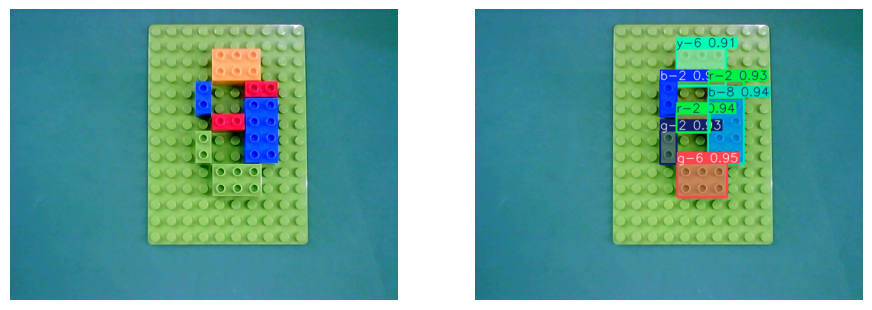

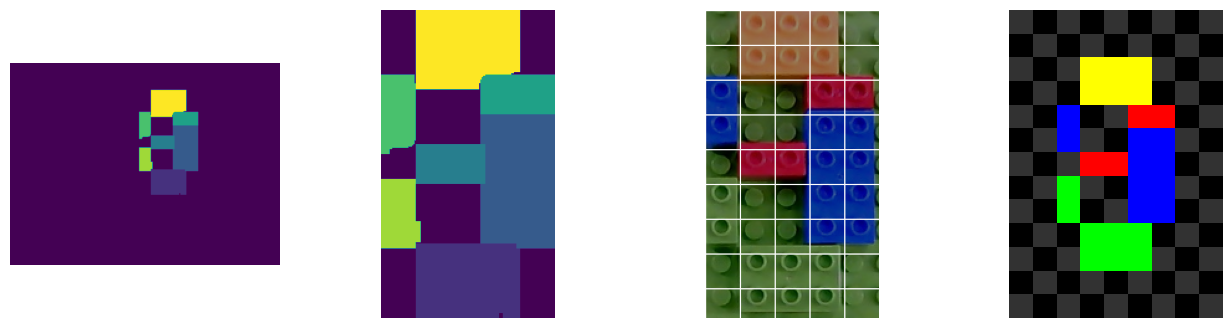

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 5 0 0 4 4 0 0]
 [0 0 5 0 0 2 2 0 0]
 [0 0 0 3 3 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
-----diassembly------
Recursive Success
duration: 0.00200s
[1, 2, 5, 6, 4, 7, 3]


In [9]:
def diassembly_approach(initial_sequence, width, height):
	np.random.shuffle(initial_sequence)
	table = make_table(initial_sequence, width, height)
	sequence = []
	start = time.time()
	rec_sol = solve_recursive(table, initial_sequence, sequence)
	end = time.time()
	if rec_sol:
		print('Recursive Success')
		duration = end - start
		print(f'duration: {duration:.5f}s')
		print([brick['id'] for brick in sequence])
		return sequence, duration
	else:
		print('Recursive Failed')
		print(f'duration: {(end-start):.5f}s')

def exhaustive_approach(initial_sequence, width, height, steps=100):
	tries, durations, checked_seq = [], [], []
	valid_seq = None
	for step in range(steps):
		np.random.shuffle(initial_sequence)
		# if [brick['id'] for brick in initial_sequence] in checked_seq:
		# 	step -= 1
		# 	continue
		# checked_seq.append([brick['id'] for brick in initial_sequence])
		table = np.zeros((height, width), dtype=np.uint8)
		start = time.time()
		step_tries, seq = solve(table, initial_sequence)
		end = time.time()
		if step_tries is None:
			print('Exhustive Failed')
			break
		else:
			if valid_seq is None:
				valid_seq = seq 
			tries.append(step_tries)
			durations.append(end-start)
	if len(tries):
		print('Exhustive Success')
		print(f'duration: {np.mean(durations):.5f}s')
		print(f'tries: {np.mean(tries):.2f} from {np.math.factorial(len(initial_sequence))} possible sequences')
		return valid_seq, np.mean(durations), np.mean(tries)

def greedy_approach(initial_sequence, width, height, steps=100):
	tries, durations, checked_seq = [], [], []
	valid_seq = None
	for step in range(steps):
		np.random.shuffle(initial_sequence)
		# if [brick['id'] for brick in initial_sequence] in checked_seq:
		# 	step -= 1
		# 	continue
		# checked_seq.append([brick['id'] for brick in initial_sequence])
		initial_sequence.sort(key=lambda b: b['size'][0]*b['size'][1])
		table = np.zeros((height, width), dtype=np.uint8)
		start = time.time()
		step_tries, seq = solve(table, initial_sequence)
		end = time.time()
		if step_tries is None:
			print('Greedy Failed')
			break
		else:
			if valid_seq is None:
				valid_seq = seq
			tries.append(step_tries)
			durations.append(end-start)
	if len(tries):
		print('Greedy Success')
		print(f'duration: {np.mean(durations):.5f}s')
		print(f'tries: {np.mean(tries):.2f} from {np.math.factorial(len(initial_sequence))} possible sequences')
		return valid_seq, np.mean(durations), np.mean(tries)

def segment(image, result, print_ratio=False):
	image_shape = (image.shape[0], image.shape[1])

	data = result[0].masks.data
	classe_names = result[0].names
	labels = result[0].boxes.cls.numpy()

	mask = np.zeros(image_shape, dtype=np.uint8)
	side_stud_ratios = []
	for i in range(len(labels)):
		# if labels[i] == find_key(classe_names, 'baseplate'):
			# continue
		label = int(labels[i])

		bounding_box = result[0].boxes.xyxy[i].numpy().astype(int)
		side1 = bounding_box[2] - bounding_box[0]
		side2 = bounding_box[3] - bounding_box[1]
		min_side = min(side1, side2)
		max_side = max(side1, side2)
		if print_ratio:
			print(f'{classe_names[label]}: {min_side}*{max_side}', end=' ')

		num_studs = int(classe_names[label].split('-')[1])

		side_stud_ratio = 1 / min_side if num_studs == 2 else 2 / min_side
		side_stud_ratios.append(side_stud_ratio)
		if print_ratio:
			print(f'ratio: {side_stud_ratio:.3f}')
		# print('----------')

		xy_coords = result[0].masks.xy[i]
		
		# Create a polygon patch
		polygon = Polygon(xy_coords, closed=True, edgecolor='r', facecolor='none')

		# Create an image mask from polygon (fill the polygon with label value)
		cv2.fillPoly(mask, np.int32([xy_coords]), (i+1, i+1, i+1))

	# if 'result.jpg' in image_file:
	#     side_stud_ratio = 1/36
	# elif 'h1.jpg' in image_file or 'h2.jpg' in image_file:
	#     side_stud_ratio = 1/147
	# else:
	side_stud_ratio = np.mean(side_stud_ratios)

	return side_stud_ratio, mask

	print(f'final ratio: {side_stud_ratio:.3f}')

def process(image, result, plot):
	# reset the fig size
	# plt.rcParams['figure.figsize'] = [3.2, 2.4]
	side_stud_ratio, orig_mask = segment(image, result)

	mask = orig_mask.copy()
	grid = cut_to_mask(mask, orig_mask)

	step_size = int(1/side_stud_ratio)
	rows = int(np.round(grid.shape[0]/step_size))
	cols = int(np.round(grid.shape[1]/step_size))
	
	matrix = np.zeros((rows, cols), )
	for i in range(rows):
		for j in range(cols):
			matrix[i][j] = np.bincount(grid[i*step_size:(i+1)*step_size, j*step_size:(j+1)*step_size].flatten()).argmax()

	labels = result[0].boxes.cls.numpy()
	classe_names = result[0].names

	bricks_labels = np.unique(matrix)
	bricks = []
	for i in bricks_labels:
		i = int(i)
		if i == 0:
			continue
		label = int(labels[i-1])

		color, num_studs = classe_names[label].split('-')
		y, x = np.where(matrix == i)

		brick = {
			'id': i,
			'coordinates': (min(x)+GRIPPER_SIZE[0], min(y)+GRIPPER_SIZE[1]),
			'size': (max(x)-min(x)+1, max(y)-min(y)+1),
			'color': color,
			'angel': 0
		}
		bricks.append(brick)

	width, height = cols+2*GRIPPER_SIZE[0], rows+2*GRIPPER_SIZE[1]

	if plot:
		plt.figure(figsize=(11, 6))
		plt.subplot(1, 2, 1)
		plt.axis('off')
		plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
		plt.subplot(1, 2, 2)
		plt.axis('off')
		plt.imshow(plot_image(result[0].plot(), True, True))
		plt.show()

		fig, axs = plt.subplots(1, 4, figsize=(16, 4))
		plot_image(orig_mask, convert_to_rgb=False, ax=axs[0])
		plot_image(grid, convert_to_rgb=False, ax=axs[1])
		draw_grid_lines(cut_to_mask(image, mask), side_stud_ratio, WHITE, line_size=1, ax=axs[2])
		plot_image(make_board(bricks, width, height, chess_like=True), ax=axs[3])
		plt.show()

	print(make_table(bricks, width, height))

	return bricks, width, height, step_size

def inference(yolo, image_file, plot=True, dis=True, exh=False, gre=False):
	image = cv2.imread(image_file)
	result = yolo(image_file)

	bricks, width, height, _ = process(image, result, plot)
	dis_results = {'sequence', 'duration'}
	exh_results = {'sequence', 'duration', 'tries'}
	gre_results = {'sequence', 'duration', 'tries'}

	if dis:
		print('-----diassembly------')
		sequence_dis, duration_dis = diassembly_approach(bricks, width, height)
		dis_results = {'sequence': sequence_dis, 'duration': duration_dis}
	if exh:
		print('-----exhaustive------')
		sequence_exh, duration_exh, tries_exh = exhaustive_approach(bricks, width, height, steps=100)
		exh_results = {'sequence': sequence_exh, 'duration': duration_exh, 'tries': tries_exh}
	if gre:
		print('-------greedy--------')
		sequence_gre, duration_gre, tries_gre = greedy_approach(bricks, width, height, steps=100)
		gre_results = {'sequence': sequence_gre, 'duration': duration_gre, 'tries': tries_gre}

	return dis_results, exh_results, gre_results

# image_file = glob.glob('./images/Simple/*.jpg')[1]
# image_file = './images/image.jpg'
image_file = './images/Simple/image82.jpg'
yolo = YOLO('./models/yolo.pt')
dis_results, exh_results, gre_results = inference(yolo, image_file)


image 1/1 d:\Users\arman\Documents\Uni\Master\Taarlab\LEGO-Reconstruction\images\Simple\image82.jpg: 480x640 1 b-2, 1 b-8, 1 g-2, 1 g-6, 2 r-2s, 1 y-6, 902.7ms
Speed: 3.0ms preprocess, 902.7ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 5 0 0 4 4 0 0]
 [0 0 5 0 0 2 2 0 0]
 [0 0 0 3 3 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 0 1 1 1 0 0 0]
 [0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
Brick 1: (70.0, 224.0)
Brick 2: (112.0, 140.0)
Brick 5: (14.0, 84.0)
Brick 6: (14.0, 168.0)
Brick 4: (112.0, 70.0)
Brick 7: (70.0, 28.0)
Brick 3: (56.0, 126.0)


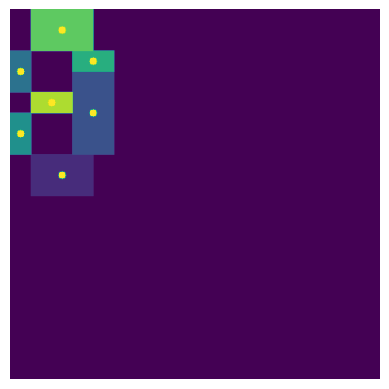

In [10]:
def find_the_first_idx_in_col(table, width, height):
	for i in range(height):
		for j in range(width):
			if table[i, j] != 0:
				return table[i, j]
	return None

def find_the_first_idx_in_row(table, width, height):
	for i in range(width):
		for j in range(height):
			if table[j, i] != 0:
				return table[j, i]
	return None

image = cv2.imread(image_file)
result = yolo(image_file)

bricks, width, height, step_size = process(image, result, plot=False)
sequence = dis_results['sequence']
table = make_table(bricks, width, height)
brick_ids = [brick['id'] for brick in sequence]
offset = [
	(sequence[brick_ids.index(find_the_first_idx_in_row(table, width, height))]['coordinates'][0] - GRIPPER_SIZE[0]) * step_size, 
	(sequence[brick_ids.index(find_the_first_idx_in_col(table, width, height))]['coordinates'][1] - GRIPPER_SIZE[1]) * step_size
]
board = np.zeros((500, 500, 1), dtype=np.uint8)
for i, brick in enumerate(sequence):
	center_x = (brick['coordinates'][0] - GRIPPER_SIZE[0] + brick['size'][0]/2) * step_size - offset[0]
	center_y = (brick['coordinates'][1] - GRIPPER_SIZE[1] + brick['size'][1]/2) * step_size - offset[1]
	print(f'Brick {brick["id"]}: ({center_x}, {center_y})')
	
	# draw the brick
	cv2.rectangle(board, (int(center_x - brick['size'][0]*step_size/2), int(center_y - brick['size'][1]*step_size/2)), 
		(int(center_x + brick['size'][0]*step_size/2), int(center_y + brick['size'][1]*step_size/2)), i+1, -1)
	
	# draw a circle in the center
	cv2.circle(board, (int(center_x), int(center_y)), 5, len(sequence)+1, -1)

	brick['pixel_position'] = (int(center_x), int(center_y))

plot_image(board, convert_to_rgb=False)

### Robot

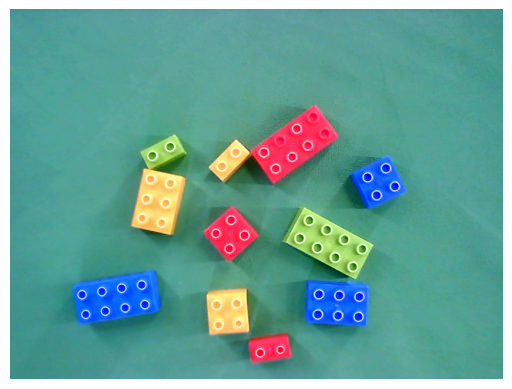

In [12]:
scene_file = 'result.jpg'
# capture_image(scene_file)
scene_image = cv2.imread(scene_file)
## Online Blob Thresholds
# FindBlobThresholds(scene_image)
blob_keypoints = FindCircles(scene_image)
plot_image(DrawCircles(scene_image, blob_keypoints))

---------------------
Brick Not Found!
id: 1 | color: g | size: (3, 2)
---------------------
Brick Found!
id: 2 | color: b | size: (2, 4) | grasp_along: length
grasp_distance: 0.0
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
between size: 25.89
rotation angle: 9.10
going to 90.00 rotation
pos dist (112, 140)
going to (112.0, 140.0)


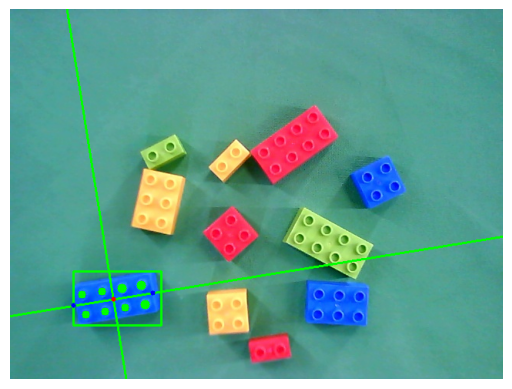

---------------------
Brick Not Found!
id: 5 | color: b | size: (1, 2)
---------------------
Brick Found!
id: 6 | color: g | size: (1, 2) | grasp_along: length
grasp_distance: 0.0
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [2 2 6 2 2 2 2 0 0]
 [2 2 6 2 2 2 2 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
between size: 25.94
rotation angle: -62.45
going to 0.00 rotation
pos dist (14, 168)
going to (14.0, 168.0)


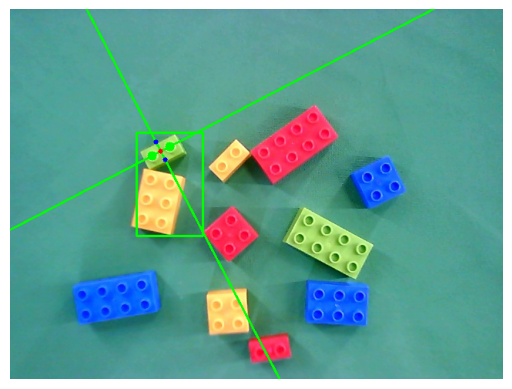

---------------------
Brick Found!
id: 4 | color: r | size: (2, 1) | grasp_along: width
grasp_distance: -0.5
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 0 0 2 2]
 [0 0 0 2 2 4 4 2 2]
 [0 0 0 0 0 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
between size: 27.29
rotation angle: -81.57
going to 90.00 rotation
pos dist (112, 70)
going to (112.0, 56.35265593604382)


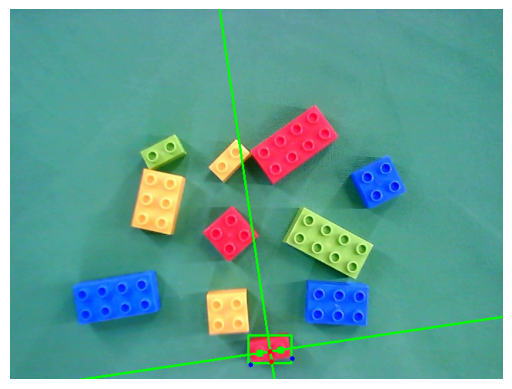

---------------------
Brick Found!
id: 7 | color: y | size: (3, 2) | grasp_along: width
grasp_distance: -0.5
[[0 0 0 2 2 0 0 0 0]
 [0 0 0 2 2 0 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 0 2 2 4 4 0 0]
 [0 0 0 2 2 2 2 0 0]
 [0 0 0 0 0 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 6 0 0 2 2 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
between size: 26.28
rotation angle: 77.13
going to 0.00 rotation
pos dist (70, 28)
going to (56.85797011480794, 28.0)


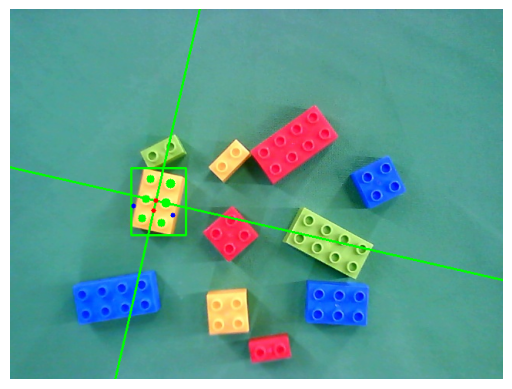

---------------------
Brick Found!
id: 3 | color: r | size: (2, 1) | grasp_along: length
grasp_distance: 0.0
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 0 7 7 7 0 0 0]
 [0 0 0 2 2 4 4 0 0]
 [0 0 0 2 2 2 2 0 0]
 [0 0 0 3 3 2 2 0 0]
 [0 0 6 2 2 2 2 0 0]
 [0 0 6 2 2 2 2 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
between size: 27.29
rotation angle: -81.57
going to 90.00 rotation
pos dist (56, 126)
going to (56.0, 126.0)


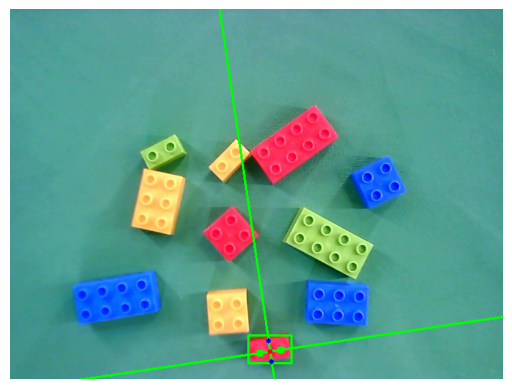

In [13]:
scene_image = cv2.imread(scene_file)
blob_keypoints = FindCircles(scene_image)
table = np.zeros((height, width), dtype=np.uint8)

for brick_dst in sequence:
	brick_range = create_brick_range(brick_dst)
	brick_coordinates = get_coords_from_range(brick_range)
	
	print('---------------------')
	total_num_studs = brick_dst['size'][0]*brick_dst['size'][1]
	brick = find_brick(scene_image, brick_dst['color'], total_num_studs, blob_keypoints)
	if brick is None:
		print('id:', brick_dst['id'], '| color:', brick_dst['color'], '| size:', brick_dst['size'])
		continue
	
	add_brick_to_table(table, brick_coordinates, brick_dst['id'])
	
	tmp_table = table.copy()
	grasp_area = find_valid_grasp_area(table, brick_range)
	draw_grasp_areas(tmp_table, grasp_area)
	
	# Determine whether the grasp is along length or along width
	brick_length_index = 1 if brick_dst['size'][0] == 2 else 0

	grasp_direction = np.argmax(np.std(grasp_area, axis=0)) # 0: horizental grasp, 1: vertical grasp
	grasp_along = 'width'
	if brick_length_index == 1: # vertical brick
		dst_rotation = 90
		if grasp_direction == 1: # vertical grasp
			grasp_along = 'length'
	else: # horizontal brick
		dst_rotation = 0
		if grasp_direction == 0: # horizental grasp
			grasp_along = 'length'

	# Determine the distance of the grasp point from the brick's center
	distance_index = np.argmin(np.std(grasp_area, axis=0))
	grasp_center = np.mean(grasp_area, axis=0)
	brick_center = np.array(brick_dst['coordinates']) + (np.array(brick_dst['size'])-1) / 2
	grasp_distance = grasp_center[distance_index] - brick_center[distance_index]
	print('id:', brick_dst['id'], '| color:', brick_dst['color'], '| size:', brick_dst['size'], '| grasp_along:', grasp_along)
	print('grasp_distance:', grasp_distance)
	print(tmp_table)
	# print(brick_dst)

	result_img = scene_image.copy()
	
	brick.draw_boundingbox(result_img)
	brick.find_studs(blob_keypoints)
	brick.cal_center_and_rotation()
	brick.draw_studs(result_img)
	brick.draw_rotationlines(result_img)
	
	if grasp_along == 'width':
		# grasp from wdith
		if dst_rotation == 90:
			grasp_distance *= -1
		grasp_mid = brick.point_on_line(brick.center, brick.rotation_angle, grasp_distance)
		draw_point(result_img, grasp_mid)
		draw_point(result_img, brick.point_on_line(grasp_mid, brick.rotation_angle - 90, -1), color=BLUE)
		draw_point(result_img, brick.point_on_line(grasp_mid, brick.rotation_angle - 90, 1), color=BLUE)
	else:
		# grasp from length
		grasp_mid = brick.point_on_line(brick.center, brick.rotation_angle - 90, grasp_distance)
		draw_point(result_img, grasp_mid)
		draw_point(result_img, brick.point_on_line(grasp_mid, brick.rotation_angle, -brick_dst['size'][brick_length_index]/2), color=BLUE)
		draw_point(result_img, brick.point_on_line(grasp_mid, brick.rotation_angle, brick_dst['size'][brick_length_index]/2), color=BLUE)
	draw_point(result_img, brick.center)

	print(f'going to {dst_rotation:.2f} rotation')
	print(f'pos dist {brick_dst["pixel_position"]}')
	if grasp_direction == 1: # vertical grasp
		new_pos = np.array(brick_dst["pixel_position"]) + np.array((grasp_distance*brick.between_size, 0))
	else: # horizental grasp
		new_pos = np.array(brick_dst["pixel_position"]) - np.array((0, grasp_distance*brick.between_size))
	print(f'going to {tuple(new_pos)}')
	
	plot_image(result_img, convert_to_rgb=True)
	